torch.Size([100, 784])


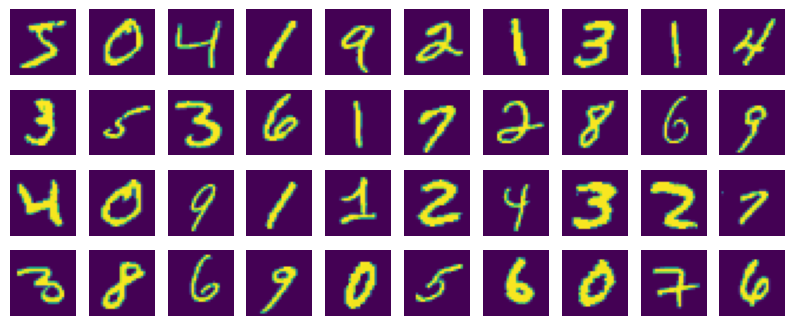

In [1]:
# LIBRARY_PATH=/usr/local/cuda-12.1/targets/x86_64-linux/lib jupyter-lab
import torch
import torchvision
import matplotlib.pyplot as plt
from simple_torch_NFFT import Fastsum
import ot
import numpy as np
import scipy
import time
from IPython import display
import h5py
import pykeops

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"

import torchvision.datasets as td
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

mnist = td.MNIST("mnist", transform=transforms.ToTensor(), download=True)
batch_size = 100
data = DataLoader(dataset=mnist, batch_size=batch_size)
y = next(iter(data))[0].view(batch_size, -1)
label = next(iter(data))[1]
#y = y[label == 4, :]
print(y.shape)

y = y.view(len(y), 28, 28)
#X = torch.cat((X,torch.rot90(X,dims=[-2,-1]),torch.rot90(X,k=2,dims=[-2,-1]) ,torch.rot90(X,k=3,dims=[-2,-1])),0)
#X = torch.cat((X, X.transpose(-2, -1)), 0).view(-1, 28**2)

fig, ax = plt.subplots(4,10, figsize=[10, 4])
ax = ax.reshape(-1)
for i in range(min(len(ax),len(y))):
    im = ax[i].imshow(y[i,:].detach().cpu().reshape(28,28))
    ax[i].axis('off')
plt.show()

y = y.view(-1, 28**2)
y = y.detach()

weights = torch.ones((len(y),), device=device) / len(y)
y = y.to(device=device)

d = y.shape[1] # data dimension
kernel = "energy" # kernel type
fastsum = Fastsum(d, kernel=kernel, device=device, slicing_mode="iid", batched_autodiff=True) # fastsum object
scale = 1.0 # kernel parameter

N = len(y) # Number of points in x

#f1 = h5py.File("distance_directions/d784/P_sym2560.h5","r")
#f1 = h5py.File("distance_directions/d784/P_sym1280.h5")
#xi0 = torch.tensor(f1['xis'], device=device, dtype=torch.float)

xi0 = torch.cat(( # Simplex
        (1+1/d)**.5 * torch.eye(d, device=device, dtype=torch.float)
        - ((d+1)**.5+1) * torch.ones((d,d), device=device, dtype=torch.float) / d**1.5,
        torch.ones((1,d), device=device, dtype=torch.float) / d**.5 ))

def rotate_points(xi):
    # random rotations for obtaining an unbiased estimator:
    d = xi.shape[-1]
    rot = torch.randn((d, d), device=device)
    rot, _ = torch.linalg.qr(rot)
    return torch.matmul(xi0, rot)

stepsize = 1 
numit = 2**15+1
shaking = False
loss_vector = torch.zeros((numit,))
momentum = 0

epoch 0: loss = 2.2724  W2 = 14.971  time = 0.16


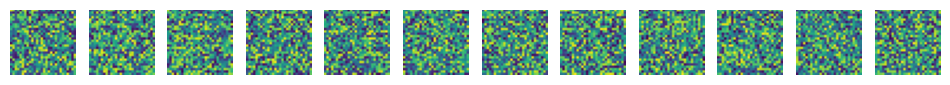

epoch 1: loss = 2.143  W2 = 14.564  time = 0.27


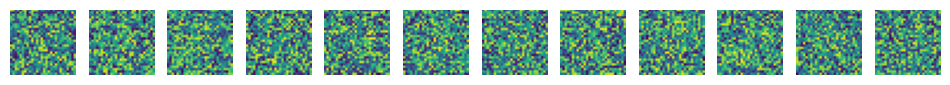

epoch 2: loss = 2.0174  W2 = 14.186  time = 0.38


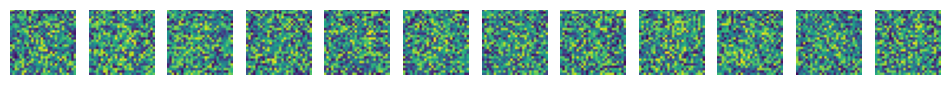

epoch 4: loss = 1.7881  W2 = 13.512  time = 0.50


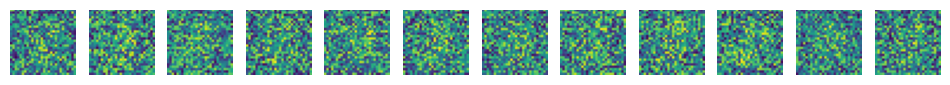

epoch 8: loss = 1.3818  W2 = 12.458  time = 0.64


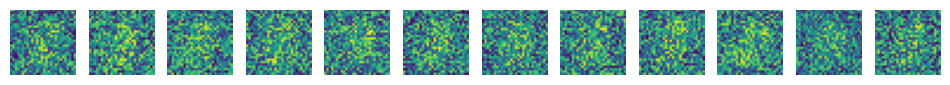

epoch 16: loss = 0.8003  W2 = 11.197  time = 1.02


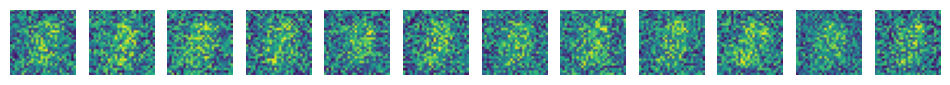

epoch 32: loss = 0.3625  W2 = 10.157  time = 1.26


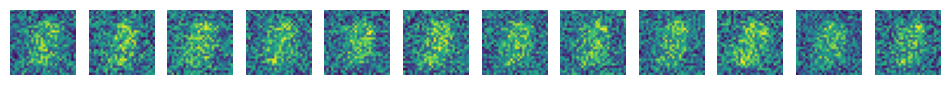

epoch 64: loss = 0.27545  W2 = 9.5345  time = 1.59


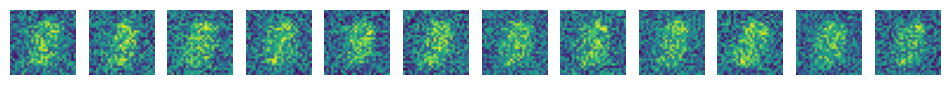

epoch 128: loss = 0.27778  W2 = 9.3013  time = 2.15


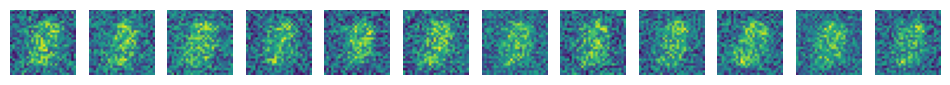

epoch 256: loss = 0.26116  W2 = 9.0336  time = 3.17


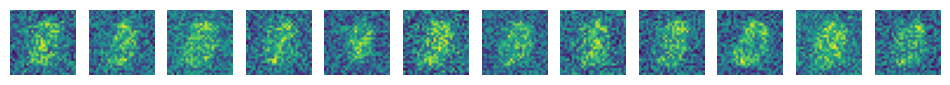

epoch 512: loss = 0.23388  W2 = 8.365  time = 5.10


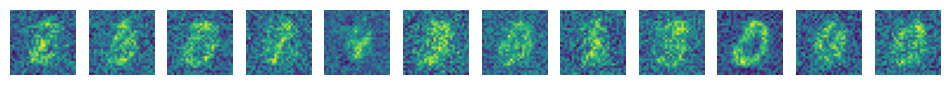

epoch 1024: loss = 0.20025  W2 = 7.433  time = 8.88


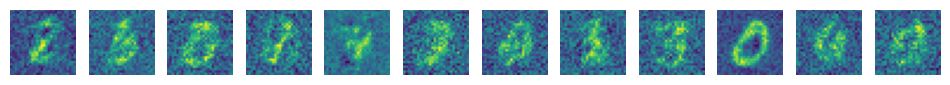

epoch 2048: loss = 0.18128  W2 = 6.3925  time = 16.34


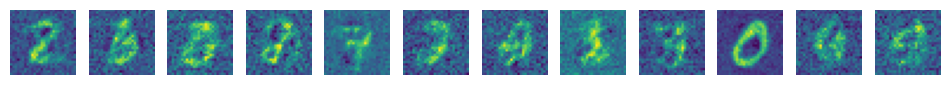

epoch 4096: loss = 0.14703  W2 = 4.6982  time = 31.18


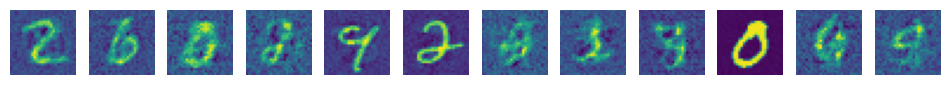

epoch 8192: loss = 0.048836  W2 = 1.2915  time = 60.92


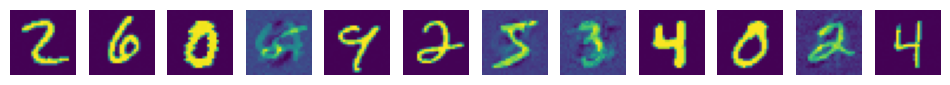

epoch 16384: loss = 0.0093424  W2 = 0.0086203  time = 120.90


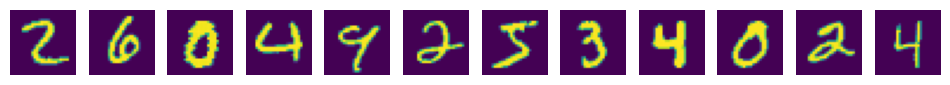

epoch 32768: loss = 0.0093424  W2 = 0.0085893  time = 240.79


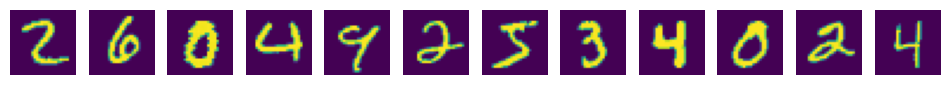

time 240.87427089875564


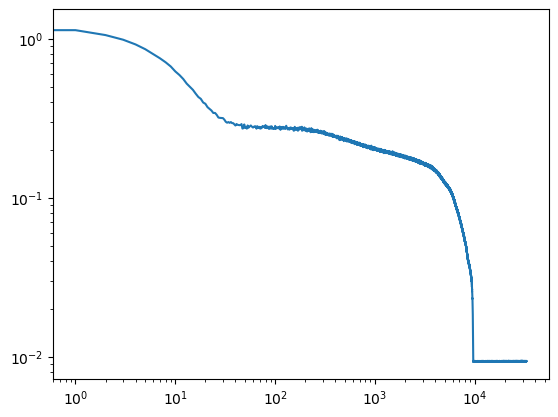

In [5]:
x = torch.rand((N, d), device=device, dtype=torch.float) 
x.requires_grad_(True)
v = torch.zeros_like(x)

def loss(xis):
    return torch.sum(-fastsum(y, x, weights, scale, xis) + 0.5* fastsum(x, x, weights, scale, xis))
def loss_0(xis):
    return torch.sum(0.5 *fastsum(y, y, weights, scale, xis))

tic = time.perf_counter()
x_saved = x.detach().cpu()[:,:,None]
for epoch in range(numit):
    xis = rotate_points(xi0)
    l = loss(xis)
    l.backward()
    with torch.no_grad():
        v = x.grad + momentum * v
        x -= stepsize * v
    x.grad.zero_()
    loss_vector[epoch] = ((l.item() + loss_0(xis)) / N).sqrt()
    if shaking and (epoch % 10 == 0) and epoch > 9:
        with torch.no_grad():  # shaking
            x += torch.randn_like(x) * np.exp(-3*epoch/numit) * (np.log(3*numit)/np.log(2) - 6) / (10 * 10)
    if (epoch & (epoch-1) == 0): #epoch % 100 == 0:
        W = ot.emd2(weights, weights, ot.dist(x.detach(),y.detach())).sqrt()
        print(f'epoch {epoch}: loss = {loss_vector[epoch]:.5g}  W2 = {W:.5g}  time = {time.perf_counter() - tic:.2f}') #l.item()
        fig, ax = plt.subplots(1,12, figsize=[12, 1])
        ax = ax.reshape(-1)
        for i in range(min(len(ax),len(y))):
            im = ax[i].imshow(x[i,:].detach().cpu().reshape(28,28))
            ax[i].axis('off')    
        plt.show()
        x_saved = torch.cat((x_saved, x.detach().cpu()[:,:,None]), dim=2)
print(f'time {time.perf_counter() - tic}')
torch.cuda.empty_cache()
plt.loglog(loss_vector[10:])

In [34]:
num_figs = x_saved.shape[2] - 6
fig, ax = plt.subplots(num_figs,10, figsize=[10, num_figs])
for i in range(10):
    for j in range(num_figs):
        im = ax[j,i].imshow(x_saved[i,:,j + 6].detach().cpu().reshape(28,28))
        ax[j,i].axis('off')   
fig.savefig(f"out/mnist_N{N}_it{epoch:06d}_m{momentum:.4g}_P{len(xi0)}_result.pdf", bbox_inches='tight', pad_inches=0.0) 
plt.close(fig)

In [ ]:
plt.loglog(loss_vector[10:])

# Sinkhorn
M = ot.dist(x.detach().cpu(),y.cpu())
print(f"Riesz kernel")
#print(f"W2 = {torch.tensordot(ot.sinkhorn(weights_x.cpu(), weights_y.cpu(), M, .1), M):.5f}")
print(f"W2 = {ot.emd2(weights.cpu(), weights.cpu(), M).sqrt():.5f}")
del M

In [58]:
rr=np.unique(np.round(2**np.linspace(0,14, 5*14+1)).astype(int))
rr

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          11,    12,    14,    16,    18,    21,    24,    28,    32,
          37,    42,    49,    56,    64,    74,    84,    97,   111,
         128,   147,   169,   194,   223,   256,   294,   338,   388,
         446,   512,   588,   676,   776,   891,  1024,  1176,  1351,
        1552,  1783,  2048,  2353,  2702,  3104,  3566,  4096,  4705,
        5405,  6208,  7132,  8192,  9410, 10809, 12417, 14263, 16384])

In [6]:
# Smoothed Riesz
x = torch.rand((N, d), device=device, dtype=torch.float) 
x.requires_grad_(True)
weights = torch.ones((N,), device=device) / N

#eps = torch.tensor(0.01, device=device, dtype=x.dtype) # kernel parameter epsilon
eps = 0.1
print(f'Smoothed Riesz eps = {eps:.4g}')

factor_C = torch.tensor(np.exp(scipy.special.loggamma(d/2) - scipy.special.loggamma((1+d)/2)) / np.sqrt(np.pi), device=device, dtype=torch.float)

def smooth_rest_f(t, scale):
    return torch.where((t/scale) > eps, 0, (eps/3 * (-(eps*t/scale)**3 + 3*(eps*t/scale)**2 + 1) - (t/scale)))
def smooth_rest_f_keops(t, scale):
    return ((t/scale) - eps).ifelse(0, eps/3 * (-(eps*t/scale)**3 + 3*(eps*t/scale)**2 + 1) - (t/scale))
def smooth_f(t, scale):
    return torch.where(torch.abs(t/scale) > eps, (t/scale).abs(), 
                        eps/3 * (-torch.abs(eps*t/scale)**3 + 3*(eps*t/scale)**2 + 1) )
def smooth_f_keops(t, scale):
    return (t/scale - eps).ifelse(t/scale, eps/3 * ((eps*t/scale)**2*(-(eps*t/scale) + 3) + 1))
    #return (t/scale).abs()

def smooth_rest_ft(t, scale):
    return torch.nan_to_num((-1 + 2*torch.pi**2 * eps**2 * scale**2 * t*t + torch.cos(2 *torch.pi * eps * scale * t))/
                        (4*torch.pi**4 * eps**2 * scale**3 * t**4),  nan=0,posinf=0,neginf=0)

fastsum2 = Fastsum(d, kernel="other", device=device, slicing_mode="orthogonal", 
                   kernel_params = {"basis_f": smooth_rest_f}, n_ft=2**14) # fastsum object 
                    # "basis_f": smooth_rest_f, "fourier_fun": smooth_rest_ft
scale = 1.0

def slice_sum(xx, yy, scale, xi):
    P_local = xi.shape[0]
    x_proj = (xx @ xi.T).reshape(-1, 1, P_local)
    y_proj = (yy @ xi.T).reshape(1, -1, P_local)
    kernel_sum = torch.sum(smooth_f((x_proj - y_proj).abs(), scale)) / P_local / len(xx)
    return kernel_sum

sums = [-slice_sum(y, x.detach(), scale, xi0) / factor_C, -0.5* slice_sum(x.detach(), x.detach(), scale, xi0) / factor_C] 
sum1 = [torch.sum(fastsum(y, x.detach(), weights, scale, xi0)), 0.5* torch.sum(fastsum(x.detach(), x.detach(), weights, scale, xi0))]
print(f'Riesz: {sum1[0]:.4f}  {sum1[1]:.4f}')
print(f'smoothabs: {sums[0]:.4f}  {sums[1]:.4f}  sum')
torch.cuda.empty_cache()

Smoothed Riesz eps = 0.1
Riesz: -1201.2976  -580.0395
smoothabs: -1191.0352  -575.4423  sum
rest = 11.1685  5.0554  for given basis_f


epoch 0: loss = 2.275  W2 = 14.99  time = 0.0629446


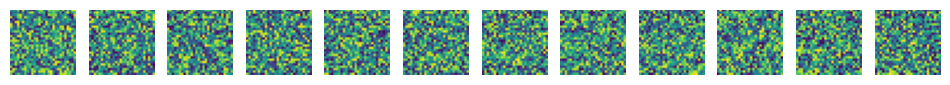

epoch 1: loss = 2.148  W2 = 14.58  time = 0.195612


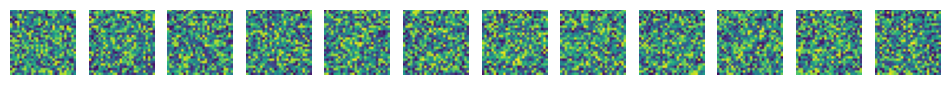

epoch 2: loss = 2.033  W2 = 14.21  time = 0.326647


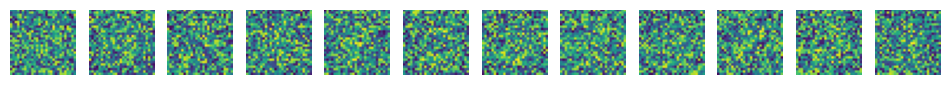

epoch 4: loss = 1.796  W2 = 13.54  time = 0.497531


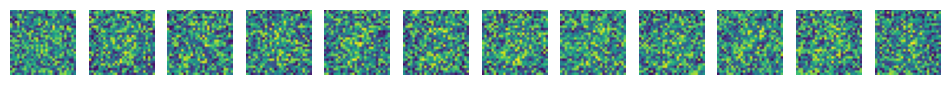

epoch 8: loss = 1.394  W2 = 12.5  time = 0.726781


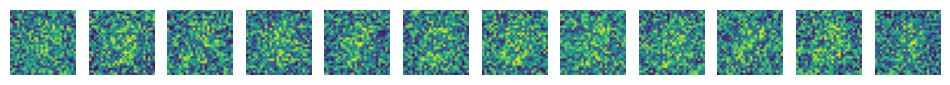

epoch 16: loss = 0.8073  W2 = 11.26  time = 1.07435


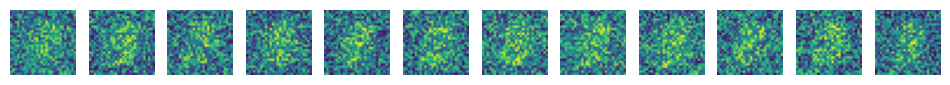

epoch 32: loss = 0.3594  W2 = 10.24  time = 1.66591


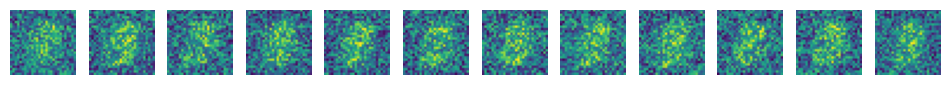

epoch 64: loss = 0.2554  W2 = 9.603  time = 2.74417


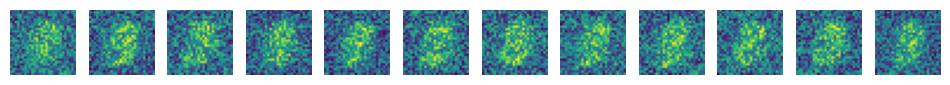

epoch 128: loss = 0.2516  W2 = 9.348  time = 4.80131


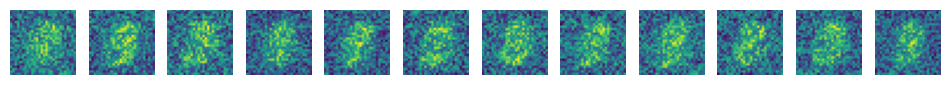

epoch 256: loss = 0.2444  W2 = 9.118  time = 8.81327


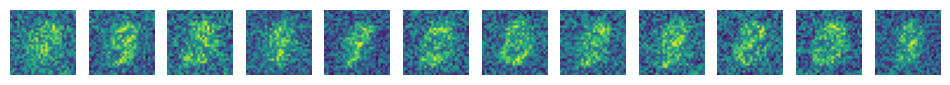

epoch 512: loss = 0.2087  W2 = 8.502  time = 16.7374


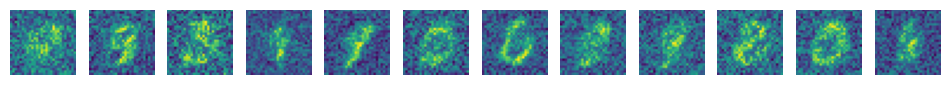

epoch 1024: loss = 0.1704  W2 = 7.587  time = 32.714


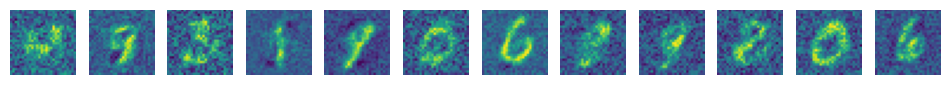

epoch 2048: loss = 0.1464  W2 = 6.61  time = 64.1719


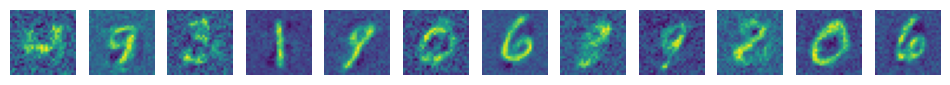

epoch 4096: loss = 0.1171  W2 = 5.2  time = 127.032


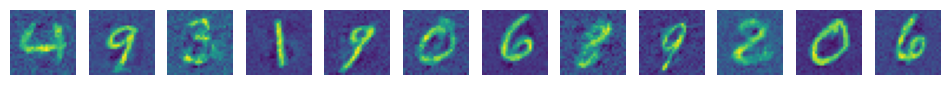

epoch 8192: loss = 0.06188  W2 = 3.417  time = 252.727


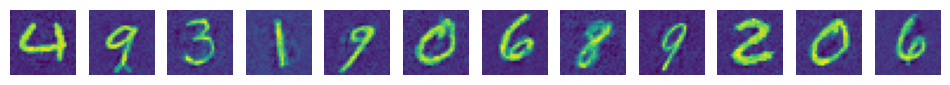

epoch 16384: loss = 0.04713  W2 = 2.803  time = 504.311


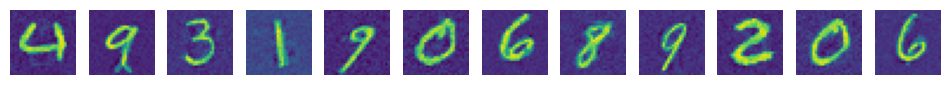

epoch 32768: loss = 0.04286  W2 = 2.78  time = 1007.15


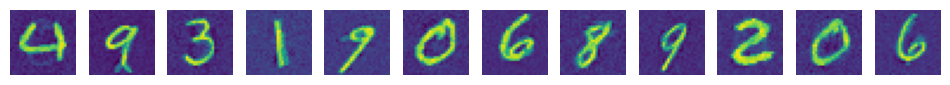

time 1007.25014455989


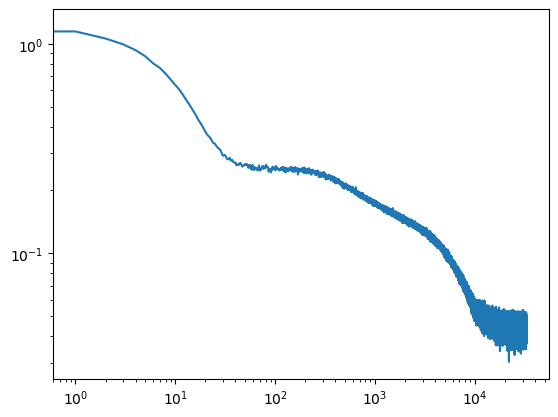

In [10]:
def loss2(xis):
    return torch.sum(-fastsum(y, x, weights, scale, xis) + 0.5* fastsum(x, x, weights, scale, xis)
                    -(-fastsum2(y, x, weights, scale, xis) + 0.5* fastsum2(x, x, weights, scale, xis))) / factor_C
def loss2keops(xis):
    return -(-slice_sum_keops(y, x, scale, xis,smooth_f_keops) 
             + 0.5* slice_sum_keops(x, x, scale, xis,smooth_f_keops)) / factor_C
def loss2naive(xi):
    return -(-slice_sum(y, x, scale, xi) + 0.5* slice_sum(x, x, scale, xi)) / factor_C
def loss2naive_0(xi):
    return -(0.5* slice_sum(y, y, scale, xi)) / factor_C

#def loss2sum(xi):
#    P_local = xi.shape[0]
#    x_proj = (x @ xi.T).reshape(-1, 1, P_local)
#    y_proj = (y @ xi.T).reshape(1, -1, P_local)
#    sum1 = torch.sum(smooth_f((x_proj - y_proj).abs(), scale)) / P_local / N
#    xx_proj = (x @ xi.T).reshape(1, -1, P_local)
#    sum2 = torch.sum(smooth_f((x_proj - xx_proj).abs(), scale)) / P_local / N
#    return - (-sum1 + 0.5*sum1) / factor_C

loss_vector = torch.zeros((numit,))
v = torch.zeros_like(x)

tic = time.perf_counter()
for epoch in range(numit):
    xis = rotate_points(xi0)
    l = loss2naive(xis)
    l.backward()
    with torch.no_grad():
        v = torch.nan_to_num(x.grad) + momentum * v
        x -= stepsize * v
    x.grad.zero_()
    loss_vector[epoch] = ((l.item() + loss2naive_0(xis)) / N).sqrt()
    if (epoch & (epoch-1) == 0):
        W = ot.emd2(weights.cpu(), weights.cpu(), ot.dist(x.detach().cpu(),y.detach().cpu())).sqrt()
        print(f'epoch {epoch}: loss = {loss_vector[epoch]:.4g}  W2 = {W:.4g}  time = {time.perf_counter() - tic:g}') #l.item()
        fig, ax = plt.subplots(1,12, figsize=[12, 1])
        ax = ax.reshape(-1)
        for i in range(len(ax)):
            im = ax[i].imshow(x[i,:].detach().cpu().reshape(28,28))
            ax[i].axis('off')   
        #fig.savefig(f"out/mnist_N{N}_smootheps{eps:.4g}_it{epoch:06d}_m{momentum:.4g}_P{len(xi0)}_result.png", bbox_inches='tight', pad_inches=0.0) 
        plt.show()

torch.cuda.empty_cache()
print(f'time {time.perf_counter() - tic}')
fig, ax = plt.subplots()
ax.loglog(loss_vector[10:])
#fig.savefig(f"out/mnist_N{N}_smootheps{eps:.4g}_it{numit}_m{momentum:.6g}_P{len(xi0)}_loss.png", bbox_inches='tight', pad_inches=0.0)

In [7]:
# Sinkhorn
tic = time.perf_counter()
M = ot.dist(x.detach().cpu(),y.detach().cpu())
print(f"Smooth Riesz eps = {eps:.5g}")
#print(f"W2 = {torch.tensordot(ot.sinkhorn(weights_x.cpu(), weights_y.cpu(), M, .1), M):.5f}")
print(f"W2 = {ot.emd2(weights.cpu(), weights.cpu(), M).sqrt():.5f}")
print(f'time {time.perf_counter() - tic}')
del M

Smooth Riesz eps = 0.01
W2 = 0.17693
time 0.018210974987596273


In [9]:
# compare with other summations

fastsum3 = Fastsum(d, kernel="other", device=device, slicing_mode="orthogonal", 
                   kernel_params = {"fourier_fun": smooth_rest_ft}, n_ft=2**10) # fastsum object 

def slice_sum_keops(x, y, scale, xi, fun):
    P_local = xi.shape[0]
    x_proj = (x @ xi.T)[:, None, :]
    y_proj = (y @ xi.T)[None, :, :]
    y_proj = pykeops.torch.LazyTensor(y_proj)
    x_proj = pykeops.torch.LazyTensor(x_proj)
    kernel_mat = fun((x_proj - y_proj).abs(), scale)
    kernel_sum = (kernel_mat).sum(2).sum(1).sum(0).squeeze() / P_local / len(x)
    return kernel_sum

sumd = [-slice_sum_keops(y, x.detach(), scale, xi0,smooth_f_keops) / factor_C, -0.5* slice_sum_keops(x.detach(), x.detach(), scale, xi0,smooth_f_keops) / factor_C] 
print(f'smoothabs: {sumd[0]:.4f}  {sumd[1]:.4f}  keops')

sums = [-slice_sum(y, x.detach(), scale, xi0) / factor_C, -0.5* slice_sum(x.detach(), x.detach(), scale, xi0) / factor_C] 
print(f'smoothabs: {sums[0]:.4f}  {sums[1]:.4f}  no_keops')

sumr = [-slice_sum_keops(y, x.detach(), scale, xi0,smooth_rest_f_keops)/factor_C, -0.5* slice_sum_keops(x.detach(), x.detach(), scale, xi0,smooth_rest_f_keops)/factor_C] 
print(f'rest = {sumr[0]:.4f}  {sumr[1]:.4f}  direct')
sum2 = [-torch.sum(fastsum2(y.detach(), x.detach(), weights, scale, xi0)) / factor_C, -0.5* torch.sum(fastsum2(x.detach(), x.detach(), weights, scale, xi0)) / factor_C]
print(f'rest = {sum2[0]:.4f}  {sum2[1]:.4f}  for given basis_f')
sum3 = [-torch.sum(fastsum3(y.detach(), x.detach(), weights, scale, xi0)) / factor_C, -0.5* torch.sum(fastsum3(x.detach(), x.detach(), weights, scale, xi0)) / factor_C]
print(f'rest = {sum3[0]:.4f}  {sum3[1]:.4f}  for given ft')

smoothabs: -1191.0360  -575.4429  keops
smoothabs: -1191.0352  -575.4423  no_keops
rest = 10.2626  4.5972  direct
rest = 11.1685  5.0554  for given basis_f
rest = -4.6931  -2.6683  for given ft


In [ ]:
# Smoothed Riesz ( old test)
x = torch.rand((N, d), device=device, dtype=torch.float)
x.requires_grad_(True)
weights = torch.ones((N,), device=device) / N

eps = torch.tensor(0.1, device=device, dtype=x.dtype) # kernel parameter epsilon
print(f'Smooted Riesz eps = {eps:.4g}')

factor_C = torch.tensor(np.exp(scipy.special.loggamma(d/2) - scipy.special.loggamma((1+d)/2)) / np.sqrt(np.pi), device=device, dtype=torch.float)

def smooth_rest_f(t, scale):
    return torch.where(torch.abs(t/scale) > eps, 0, (eps/3 * (-torch.abs(eps*t/scale)**3 + 3*(eps*t/scale)**2 + 1) 
                       - torch.abs(t/scale)))
def smooth_rest_f_keops(t, scale):
    return ((t/scale).abs() - eps).ifelse(0, eps/3 * (-(eps*t/scale).abs()**3 + 3*(eps*t/scale)**2 + 1) 
                       - (t/scale).abs())
def smooth_f(t, scale):
    return torch.where(torch.abs(t/scale) > eps, (t/scale).abs(), eps/3 * (-torch.abs(eps*t/scale)**3 + 3*(eps*t/scale)**2 + 1) )
def smooth_f_keops(t, scale):
    return ((t/scale).abs() - eps).ifelse((t/scale).abs(), eps/3 * (-(eps*t/scale).abs()**3 + 3*(eps*t/scale)**2 + 1))
    #return (t/scale).abs()

def smooth_rest_ft(t, scale):
    return torch.nan_to_num((-1 + 2*torch.pi**2 * eps**2 * scale**2 * t*t + torch.cos(2 *torch.pi * eps * scale * t))/
                        (4*torch.pi**4 * eps**2 * scale**3 * t**4) / factor_C,  nan=0,posinf=0,neginf=0)

fastsum2 = Fastsum(d, kernel="other", device=device, slicing_mode="orthogonal", 
                   kernel_params = {"basis_f": smooth_rest_f}) # fastsum object 
                    # "basis_f": smooth_rest_f, "fourier_fun": smooth_rest_ft

fastsum3 = Fastsum(d, kernel="other", device=device, slicing_mode="orthogonal", 
                   kernel_params = {"fourier_fun": smooth_rest_ft}) # fastsum object 
scale = 1.0

def slice_sum_keops(x, y, x_weights, scale, xi):
    P_local = xi.shape[0]
    x_proj = (x @ xi.T)[:, None, :]
    y_proj = (y @ xi.T)[None, :, :]
    x_weights = x_weights[:, None, None]
    y_proj = pykeops.torch.LazyTensor(y_proj)
    x_proj = pykeops.torch.LazyTensor(x_proj)
    x_weights = pykeops.torch.LazyTensor(x_weights)
    distance_mat = ((x_proj - y_proj) ** 2).sqrt()
    kernel_mat = smooth_f_keops(distance_mat, scale)
    kernel_sum = (kernel_mat * x_weights).sum(2).sum(1).sum(0).squeeze() / P_local
    return kernel_sum

def slice_sum(x, y, x_weights, scale, xi):
    P_local = xi.shape[0]
    x_proj = (x @ xi.T)[:, None, :]
    y_proj = (y @ xi.T)[None, :, :]
    x_weights = x_weights[:, None]
    #y_proj = pykeops.torch.LazyTensor(y_proj)
    #x_proj = pykeops.torch.LazyTensor(x_proj)
    #x_weights = pykeops.torch.LazyTensor(x_weights, axis=0)
    distance_mat = ((x_proj - y_proj) ** 2).sqrt()
    kernel_mat = smooth_f(distance_mat, scale)
    kernel_sum = (kernel_mat * x_weights).sum(2).sum(1).sum(0) / P_local
    return kernel_sum

In [ ]:
sumd = [-slice_sum_keops(y, x, weights, scale, xi0) / factor_C, -0.5* slice_sum_keops(x, x, weights, scale, xi0) / factor_C] 
sum1 = [torch.sum(fastsum(y, x, weights, scale, xi0)), 0.5* torch.sum(fastsum(x, x, weights, scale, xi0))]
sum2 = [-torch.sum(fastsum2(y, x, weights, scale, xi0)) / factor_C, -0.5* torch.sum(fastsum2(x, x, weights, scale, xi0)) / factor_C]
sum3 = [-torch.sum(fastsum3(y, x, weights, scale, xi0)) / factor_C, -0.5* torch.sum(fastsum3(x, x, weights, scale, xi0)) / factor_C]
print(f'Riesz: {sum1[0]:.4f}  {sum1[1]:.4f}')
print(f'loss = {sum2[0]:.4f}  {sum2[1]:.4f}  for given basis_f')
print(f'loss = {sum3[0]:.4f}  {sum3[1]:.4f}  for given ft')
print(f'loss = {sumd[0]:.4f}  {sumd[1]:.4f}  direct')

In [ ]:
def loss2():
    xis = rotate_points(xi0)
    return torch.sum(-fastsum(y, x, weights, scale, xis) + 0.5* fastsum(x, x, weights, scale, xis)
                    -(-fastsum2(y, x, weights, scale, xis) + 0.5* fastsum2(x, x, weights, scale, xis)) / factor_C)
def loss2naive():
    xis = rotate_points(xi0)
    return -(-slice_sum_keops(y, x, weights, scale, xis) + 0.5* slice_sum_keops(x, x, weights, scale, xis)) / factor_C

#l = loss2naive()
#l.backward()
#with torch.no_grad():
#    print(x.grad)

In [ ]:
tic = time.perf_counter()
loss_vector = torch.zeros((numit,))
v = torch.zeros_like(x)

for epoch in range(numit):
    l = loss2naive()
    l.backward()
    with torch.no_grad():
        v = x.grad + momentum * v
        x -= stepsize * v
    x.grad.zero_()
    loss_vector[epoch] = l.item() / N
    if (epoch & (epoch-1) == 0):
        print(f'epoch {epoch}: loss = {loss_vector[epoch]:.4f}  time = {time.perf_counter() - tic:g}') #l.item()
        fig, ax = plt.subplots(1,10, figsize=[10, 1])
        ax = ax.reshape(-1)
        for i in range(10):
            im = ax[i].imshow(x[i,:].detach().cpu().reshape(28,28))
            ax[i].axis('off')   
        fig.savefig(f"out/mnist_N{N}_smootheps{eps:.4g}_it{epoch:06d}_m{momentum:.4g}_P{len(xi0)}_result.png", bbox_inches='tight', pad_inches=0.0) 
        plt.show()

torch.cuda.empty_cache()
print(f'time {time.perf_counter() - tic}')
fig, ax = plt.subplots()
ax.loglog(loss_vector[10:])
fig.savefig(f"out/mnist_N{N}_smootheps{eps:.4g}_it{numit}_m{momentum:.6g}_P{len(xi0)}_loss.png", bbox_inches='tight', pad_inches=0.0)

In [ ]:
torch.cuda.get_device_name()

In [ ]:
print(torch.cuda.memory_summary())